In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, f1_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [2]:

actReading_11_df = pd.read_csv('../dataframes/actReading_11.csv')

In [3]:
actReading_11_df.head()

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,...,course_YearbkII9-12,course_Yearbook9-12,course_YrbkIII9-12,school_High School A,school_High School B,school_High School C,school_High School D,iready_math,iready_reading,bbb_literacy
0,45054,False,0.444444,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
1,45054,False,0.444444,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,0,0,0
2,45440,True,1.055556,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
3,45440,True,1.055556,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0
4,45440,True,1.055556,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,0,0,0


#Trying PCA

In [4]:
#doing PCA to get the columns that are impacted most by proficient_score label 

# Initialize scaler and scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(actReading_11_df.drop(['proficient_score', 'studentId', 'is_proficient'], axis=1))

# Perform PCA
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_sum = 0
components = 0

for variance in explained_variance_ratio:
    cumulative_sum += variance
    components += 1
    if cumulative_sum >= 0.80:  # Adjust to your threshold (80%)
        break

print(f"Number of components needed: {components}")
print(f"Cumulative explained variance: {cumulative_sum}")




Number of components needed: 107
Cumulative explained variance: 0.8008126029661587


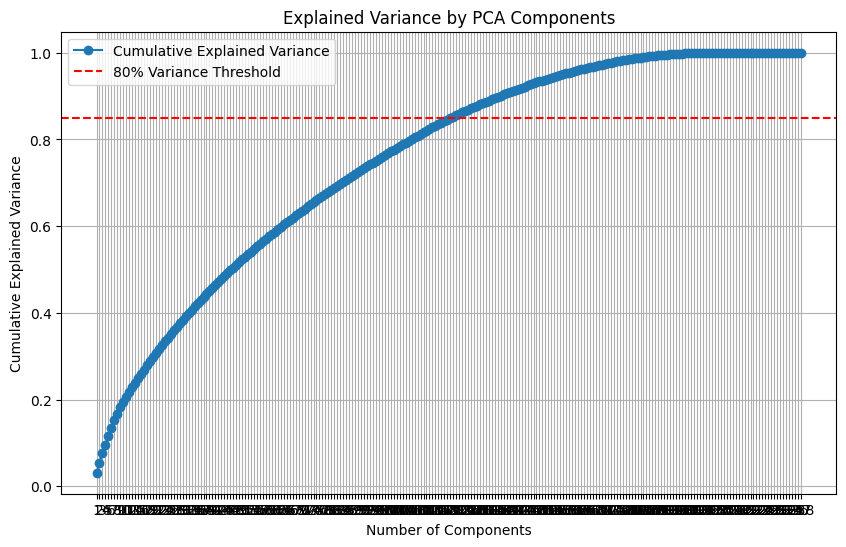

Number of components needed: 107


In [5]:
pca = PCA()  # Initialize PCA without specifying components
pca.fit(X_scaled)

# Explained variance ratios
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.axhline(y=0.85, color='r', linestyle='--', label='80% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend()
plt.grid()
plt.show()

# Calculate the number of components needed to explain at least 80% variance
components = np.argmax(cumulative_variance >= 0.80) + 1  # Add 1 to get the count of components
print(f"Number of components needed: {components}")

In [6]:
X_pca = pca.transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
first_108_pcs_df = X_pca_df.iloc[:, :108].copy()
#first_108_pcs_df


In [7]:
print(pca.components_.shape)
print(actReading_11_df.columns)

cols_drop = ['studentId', 'is_proficient', 'proficient_score']
columns_to_drop = [col for col in cols_drop if col in actReading_11_df.columns]
feature_names = actReading_11_df.drop(columns=columns_to_drop).columns

(238, 238)
Index(['studentId', 'is_proficient', 'proficient_score', 'course_ACT Review',
       'course_ACT/WK Rev.', 'course_ACTReview.5C', 'course_AG Communica',
       'course_AIDE-ELEM', 'course_AIDE-LIB', 'course_ALG I B ACCE',
       ...
       'course_YearbkII9-12', 'course_Yearbook9-12', 'course_YrbkIII9-12',
       'school_High School A', 'school_High School B', 'school_High School C',
       'school_High School D', 'iready_math', 'iready_reading',
       'bbb_literacy'],
      dtype='object', length=241)


In [8]:
components = pca.components_[:108]  
# Create a DataFrame for feature loadings
# Rows correspond to features, and columns correspond to principal components
feature_loadings_df = pd.DataFrame(
    components.T,  # Transpose to match features as rows
    columns=[f'PC{i+1}' for i in range(components.shape[0])],  # PC1, PC2, ..., PC108
    index= feature_names  # Feature names
)

# Initialize a list to store the top features across all principal components
all_top_features = []

# For each principal component, find the top features
for pc in feature_loadings_df.columns:
    # Get the absolute values of the loadings and sort them
    sorted_features = feature_loadings_df[pc].abs().sort_values(ascending=False)
    # Get the top 5 features for the current principal component (adjustable)
    top_features = sorted_features.head(5).index.tolist()
    # Add the component and its top features to the list
    for feature in top_features:
        all_top_features.append((pc, feature))

# Create a DataFrame to view all top features for each principal component
top_features_df = pd.DataFrame(all_top_features, columns=['Principal Component', 'Top Feature'])

# Display the DataFrame
print(top_features_df)

    Principal Component           Top Feature
0                   PC1    course_HEALTH 9-12
1                   PC1     course_DRIVERS ED
2                   PC1  school_High School B
3                   PC1    course_D&TSafetyEd
4                   PC1    course_Health 9-12
..                  ...                   ...
535               PC108     course_Accounting
536               PC108   course_Food Nutritn
537               PC108   course_Bus Tech App
538               PC108      course_Vocal I 1
539               PC108   course_AlgEnrichmet

[540 rows x 2 columns]


In [9]:
top_features_df.head(15)

,Principal Component,Top Feature
0,PC1,course_HEALTH 9-12
1,PC1,course_DRIVERS ED
2,PC1,school_High School B
3,PC1,course_D&TSafetyEd
4,PC1,course_Health 9-12
5,PC2,course_Physical Sci
6,PC2,course_English Gr10
7,PC2,course_Algebra I B
8,PC2,course_USHis I G10
9,PC2,course_US His-1877


In [10]:
# Find the most positively and negatively correlated features with each principal component
positive_correlations = {}
negative_correlations = {}

# Iterate through the loadings for each component
for pc in feature_loadings_df.columns:
    # Get the features with positive correlations (largest positive values)
    positive_features = feature_loadings_df[pc][feature_loadings_df[pc] > 0].sort_values(ascending=False)
    negative_features = feature_loadings_df[pc][feature_loadings_df[pc] < 0].sort_values(ascending=True)
    
    # Store the positive and negative correlations
    positive_correlations[pc] = positive_features
    negative_correlations[pc] = negative_features

# Print the results
print("Positive Correlations:")
for pc, features in positive_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 positively correlated features

print("\nNegative Correlations:")
for pc, features in negative_correlations.items():
    print(f"{pc}: {features.head()}")  # Display top 5 negatively correlated features


Positive Correlations:
PC1: course_HEALTH 9-12      0.264790
course_DRIVERS ED       0.264070
school_High School B    0.239296
course_BullBogAdv       0.216602
course_HS US 10 ADV     0.188434
Name: PC1, dtype: float64
PC2: course_Physical Sci    0.381151
course_English Gr10    0.369782
course_Algebra I B     0.333015
course_USHis I G10     0.243515
course_US His-1877     0.231576
Name: PC2, dtype: float64
PC3: course_Eng Gr10 Adv    0.282517
course_ChemistryAdv    0.276097
course_USHis I Adv     0.218905
course_HS US 10 ADV    0.210925
course_D&TSafetyEd     0.198732
Name: PC3, dtype: float64
PC4: course_Ess II:USHis    0.370785
course_Ess: Phy Sci    0.348151
course_Eng Ess 10      0.346929
course_Alg Esntls B    0.330824
course_RdIntrv7-12     0.235180
Name: PC4, dtype: float64
PC5: course_Eng Gr10 Adv     0.223264
course_ChemistryAdv     0.221091
course_USHis I Adv      0.210761
course_Panther Adv      0.210207
school_High School A    0.210207
Name: PC5, dtype: float64
PC6: course_

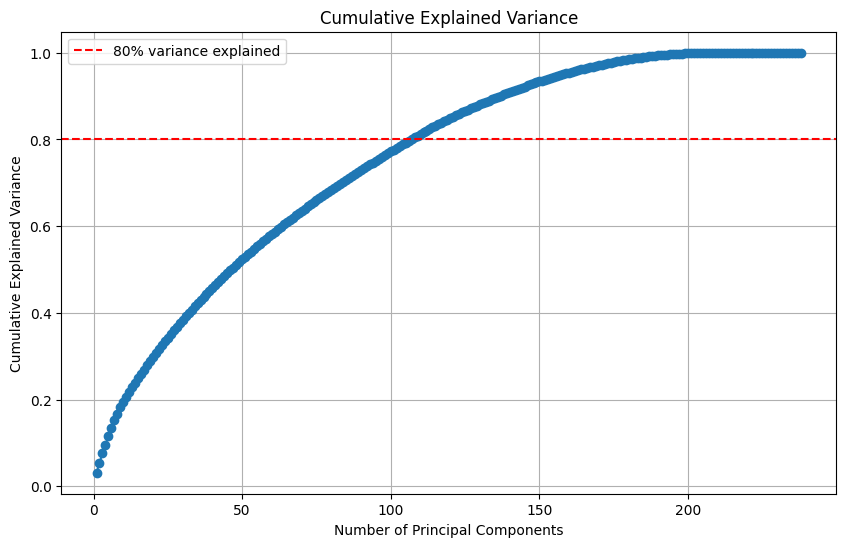

In [11]:
# Cumulative Explained Variance
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance explained')  # Adjust threshold as needed
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend()
plt.grid(True)
plt.show()

Training PCA

In [12]:
X = first_108_pcs_df  # PCA-transformed features
y = actReading_11_df['proficient_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)
print(X_train.shape)

(2062, 108)


In [13]:
#possible hyperparameters
max_depth_values= [8,12,25,32]
min_samples_leaf_values = [4,5,8,10]
param_grid = {'max_depth' : list(max_depth_values), 'min_samples_leaf' : list(min_samples_leaf_values)}


#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressor = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_grid = GridSearchCV(dt_regressor, param_grid, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_search = dt_grid.fit(X_train, y_train)

print("Done")
dt_best_params = dt_grid_search.best_params_

dt_best_params

#{'max_depth': 32, 'min_samples_leaf': 5}

Running Grid Search
Done


{'max_depth': 32, 'min_samples_leaf': 5}

In [14]:
dt_model = DecisionTreeRegressor(max_depth=32, min_samples_leaf=5)
dt_model.fit(X_train,y_train)

#testing model on the X_test
y_dt_pred = dt_model.predict(X_test)
dt_rmse = mean_squared_error(y_test,y_dt_pred,squared=False)
dt_r2 = r2_score(y_test,y_dt_pred)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_bool = y_dt_pred >= threshold
y_test_bool = y_test >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_bool, y_pred_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmse))
print('[DT] R2: {0}'.format(dt_r2))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.71      0.94      0.81       281
        True       0.88      0.54      0.67       235

    accuracy                           0.76       516
   macro avg       0.80      0.74      0.74       516
weighted avg       0.79      0.76      0.75       516

[DT] Root Mean Squared Error: 0.2501940307168663
[DT] R2: 0.32495581428678344


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [15]:
micro_f1 = f1_score(y_test_bool, y_pred_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7596899224806202


no PCA

In [16]:
print(actReading_11_df.dtypes)

studentId                 int64
is_proficient              bool
proficient_score        float64
course_ACT Review          bool
course_ACT/WK Rev.         bool
                         ...   
school_High School C       bool
school_High School D       bool
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object


In [17]:
#changing all bools to ints 0 and 1 for the model
actReading_11_df[actReading_11_df.select_dtypes(include=['bool']).columns] = actReading_11_df.select_dtypes(include=['bool']).astype(int)
actReading_11_df.dtypes

studentId                 int64
is_proficient             int64
proficient_score        float64
course_ACT Review         int64
course_ACT/WK Rev.        int64
                         ...   
school_High School C      int64
school_High School D      int64
iready_math               int64
iready_reading            int64
bbb_literacy              int64
Length: 241, dtype: object

In [18]:
proficient_score = actReading_11_df['proficient_score'].describe()[['min','max']]
print(proficient_score)

min    0.222222
max    1.972222
Name: proficient_score, dtype: float64


Training

In [19]:
#Create Training and Test Data
yRead = actReading_11_df['proficient_score']
XRead= actReading_11_df.drop(['proficient_score','is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(XRead.shape[0]))

X_trainRead,X_testRead, y_trainRead,y_testRead  = train_test_split(XRead,yRead, test_size=0.20,stratify = actReading_11_df['is_proficient'],random_state=123)
print(X_trainRead.shape)
print(X_testRead.shape)

#possible hyperparameters
max_depth_valuesRead = [8,12,25,32]
min_samples_leaf_valuesRead = [4,5,8,10]
param_gridRead = {'max_depth' : list(max_depth_valuesRead), 'min_samples_leaf' : list(min_samples_leaf_valuesRead)}


Number of examples: 2578
(2062, 238)
(516, 238)


In [20]:
#Grid Search to find the best hyperparameters 
print("Running Grid Search")
dt_regressorRead = DecisionTreeRegressor()

# will have a 3-fold cross validation 
dt_gridRead = GridSearchCV(dt_regressorRead, param_gridRead, cv=3, scoring='neg_root_mean_squared_error')
dt_grid_searchRead = dt_gridRead.fit(X_trainRead, y_trainRead)

print("Done")
dt_best_paramsRead = dt_grid_searchRead.best_params_

dt_best_paramsRead
#{'max_depth': 32, 'min_samples_leaf': 4}


Running Grid Search
Done


{'max_depth': 32, 'min_samples_leaf': 4}

In [21]:
dt_modelRead = DecisionTreeRegressor(max_depth=32, min_samples_leaf=4)
dt_modelRead.fit(X_trainRead,y_trainRead)

#testing model on the X_test
y_dt_predRead = dt_modelRead.predict(X_testRead)
dt_rmseRead = mean_squared_error(y_testRead,y_dt_predRead,squared=False)
dt_r2Read = r2_score(y_testRead,y_dt_predRead)

#trying to get f1 and accuracy score 
threshold = 1
y_pred_read_bool = y_dt_predRead >= threshold
y_test_read_bool = y_testRead >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_read_bool, y_pred_read_bool))

print('[DT] Root Mean Squared Error: {0}'.format(dt_rmseRead))
print('[DT] R2: {0}'.format(dt_r2Read))

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.69      0.90      0.78       289
        True       0.79      0.47      0.59       227

    accuracy                           0.71       516
   macro avg       0.74      0.69      0.69       516
weighted avg       0.73      0.71      0.70       516

[DT] Root Mean Squared Error: 0.25033444159223744
[DT] R2: 0.3741857096950487


c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Based on these metrics, model is having a difficult time with predicting if a student is actaully proficent. we know that most of the students are below proficentcy and that there is a class imbalance. 


In [22]:
#looking at the micro score
micro_f1 = f1_score(y_test_read_bool, y_pred_read_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7131782945736435


Confusion Matrix:
[[261  28]
 [120 107]]


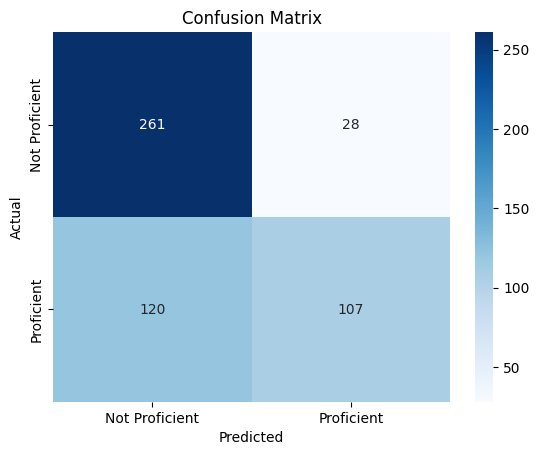

In [23]:
cm = confusion_matrix(y_test_read_bool, y_pred_read_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [24]:
#I am worried about the false positive but it seems low

Feature Importance

In [25]:
importances = dt_modelRead.feature_importances_
feature_names = X_trainRead.columns

# Combine names and importances, and sort
importance_dfRead = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_dfRead= importance_dfRead.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_dfRead)

                 Feature  Importance
76   course_Eng Gr10 Adv    0.339077
84     course_Enviro Sci    0.047374
158  course_Physical Sci    0.039886
177     course_Spanish 1    0.035955
220     course_Vocal I 1    0.034079
..                   ...         ...
225  course_WH 1500-P-CR    0.000000
223   course_Vocal III 1    0.000000
224    course_W H 1500-P    0.000000
230   course_YrbkIII9-12    0.000000
237         bbb_literacy    0.000000

[238 rows x 2 columns]


In [26]:
importance_dfRead.head(15)

,Feature,Importance
76,course_Eng Gr10 Adv,0.339077
84,course_Enviro Sci,0.047374
158,course_Physical Sci,0.039886
177,course_Spanish 1,0.035955
220,course_Vocal I 1,0.034079
234,school_High School D,0.032092
29,course_Algebra I B,0.021061
208,course_VarFBI,0.020025
24,course_Alg II/Trig,0.018624
85,course_Ess II:USHis,0.017586


SHAP on non PCA

In [27]:
import shap

c:\Users\lmmag\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [28]:
explainer = shap.Explainer(dt_modelRead)
shap_test = explainer(X_testRead)
shap_df = pd.DataFrame(shap_test.values, columns=shap_test.feature_names,
  index=X_testRead.index)
# Fetch the importances
shap_df = shap_df.apply(np.abs).mean().sort_values(ascending=False)
print(shap_df)

course_Eng Gr10 Adv    0.078549
course_Physical Sci    0.051145
course_Algebra I B     0.022826
course_Spanish 1       0.014338
course_US His-1877     0.013578
                         ...   
course_WH 1500-P-CR    0.000000
course_Vocal III 1     0.000000
course_W H 1500-P      0.000000
course_YrbkIII9-12     0.000000
bbb_literacy           0.000000
Length: 238, dtype: float64


<Axes: title={'center': 'Top 10 Important Features'}>

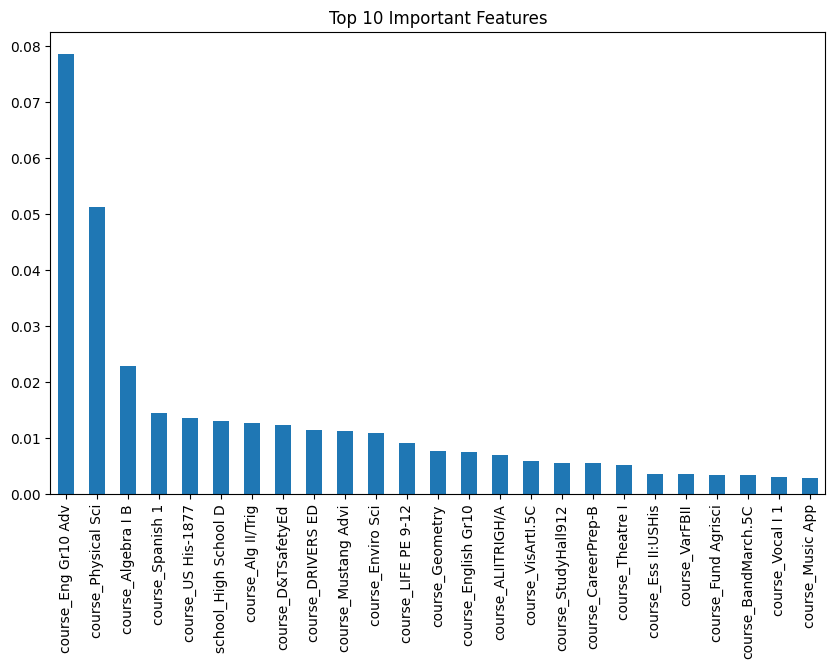

In [29]:
shap_df.head(25).plot(kind='bar', title='Top 10 Important Features', figsize=(10, 6))
